In [1]:
import random, gc, os, pickle, csv, time

import datasets.utils
import models.utils
from models.cls_oml_ori_v2 import OML
from models.base_models_ori import LabelAwareReplayMemory

import numpy as np
import matplotlib.pyplot as plt

import higher
import torch
import torch.nn.functional as F
from torch.utils import data

# Constants

In [2]:
dataset_order_mapping = {
    1: [2, 0, 3, 1, 4],
    2: [3, 4, 0, 1, 2],
    3: [2, 4, 1, 3, 0],
    4: [0, 2, 1, 4, 3]
}
n_classes = 33
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
# model_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518612.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456804.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477968.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869765.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241546.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424113.pt"
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167637.pt"

# v. SR 
# model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695669.pt"
# v. SR Query
model_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228.pt"

# memory_path = "/data/model_runs/original_oml/aOML-order1-2022-07-18/OML-order1-id4-2022-07-18_17-53-13.518639_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr002-2022-07-31/OML-order1-id4-2022-07-31_14-53-46.456828_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-2022-07-31/OML-order1-id4-2022-07-31_18-47-41.477992_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr005-up20-2022-08-01/OML-order1-id4-2022-08-01_14-45-55.869797_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-07-31/OML-order1-id4-2022-07-31_21-18-36.241572_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr020-2022-08-16/OML-order1-id4-2022-08-16_11-37-19.424139_memory.pickle"
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr050-2022-08-16/OML-order1-id4-2022-08-16_14-16-12.167666_memory.pickle"
# v. SR 
# memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-29-sr/OML-order1-id4-2022-08-29_18-10-31.695692_memory.pickle"
# v. SR Query
memory_path = "/data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854254_memory.pickle"


# new_memory_path, ext = os.path.splitext(memory_path)
# new_memory_path = new_memory_path + "_label" + ext

use_db_cache = True
cache_dir = 'tmp'

In [3]:
args = {
    "order": 1,
    "n_epochs": 1,
    "lr": 3e-5,
    "inner_lr": 0.001*10,
    "meta_lr": 3e-5,
    "model": "bert",
    "learner": "oml",
    "mini_batch_size": 16,
    "updates": 5*1,
    "write_prob": 1.0,
    "max_length": 448,
    "seed": 42,
    "replay_rate": 0.01,
    "replay_every": 9600
}
updates = args["updates"]
mini_batch_size = args["mini_batch_size"]
order = args["order"]

In [4]:
torch.manual_seed(args["seed"])
random.seed(args["seed"])
np.random.seed(args["seed"])

# Load Dataset

In [5]:
print('Loading the datasets')
test_datasets = []
for dataset_id in dataset_order_mapping[order]:
    test_dataset_file = os.path.join(cache_dir, f"{dataset_id}.cache")
    if os.path.exists(test_dataset_file):
        with open(test_dataset_file, 'rb') as f:
            test_dataset = pickle.load(f)
    else:
        test_dataset = datasets.utils.get_dataset_test("", dataset_id)
        print('Loaded {}'.format(test_dataset.__class__.__name__))
        test_dataset = datasets.utils.offset_labels(test_dataset)
        pickle.dump(test_dataset, open( test_dataset_file, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Pickle saved at {test_dataset_file}")
    test_datasets.append(test_dataset)
print('Finished loading all the datasets')

Loading the datasets
Finished loading all the datasets


# Load Model

In [6]:
learner = OML(device=device, n_classes=n_classes, **args)
print('Using {} as learner'.format(learner.__class__.__name__))
learner.load_model(model_path)
with open(memory_path, 'rb') as f:
#     learner.memory = pickle.load(f)
    memory_buffer = pickle.load(f)


2022-11-28 10:42:38,479 - transformers.tokenization_utils_base - INFO - loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /root/.cache/torch/transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2022-11-28 10:42:39,773 - transformers.configuration_utils - INFO - loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /root/.cache/torch/transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2022-11-28 10:42:39,776 - transformers.configuration_utils - INFO - Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer

Using OML as learner


In [7]:
# Setting up task dict for task-aware
memory_buffer.task_dict = {
    0: list(range(5, 9)), # AG
    1: list(range(0, 5)), # Amazon
    2: list(range(0, 5)), # Yelp
    3: list(range(9, 23)), # DBPedia
    4: list(range(23, 33)), # Yahoo
}

In [8]:
# label to task converter - hack, since normally we would just use the task token/identifier
def get_task_from_label(label_idx, task_dict):
    for task_idx, class_list in task_dict.items():
        if label_idx in class_list: return task_idx
    return -1
print(get_task_from_label(8, memory_buffer.task_dict))
# Find mode: https://stackoverflow.com/questions/10797819/finding-the-mode-of-a-list
def mode(array):
    return max(array, key = array.count)
# label list to task id
def get_task_from_label_list(label_list, task_dict):
    return mode([get_task_from_label(label, task_dict) for label in label_list])
print(get_task_from_label_list([1,2,32,1,4,2,0], memory_buffer.task_dict))

0
1


In [9]:
dataclass_mapper = {
    "AGNewsDataset": 0,
    "AmazonDataset": 1,
    "YelpDataset": 2,
    "DBPediaDataset": 3,
    "YahooAnswersDataset": 4
}
dataclass_mapper["AGNewsDataset"]

0

In [10]:
# Trim buffer dict to 1000 per class
memory_buffer.reset_meta()
memory_buffer.trim_buffer_dict()

In [11]:
len(memory_buffer.buffer_dict[0])

1000

# Get Scores for each sample in ER

In [12]:
# Returns loss,preds,labels, labels_conf
def validate(fpln, validation_set):
    all_valid_preds, all_valid_labels, all_valid_label_conf = [], [], []
    
    for valid_text, valid_labels, _ in validation_set:        
        valid_labels = torch.tensor(valid_labels).to(device)
        valid_input_dict = learner.rln.encode_text(valid_text)
        valid_repr = learner.rln(valid_input_dict)
        valid_output = fpln(valid_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
        valid_loss = learner.loss_fn(valid_output, valid_labels)
        valid_loss = valid_loss.item()

        # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
        valid_output_softmax = F.softmax(valid_output, -1)
        valid_label_conf = valid_output_softmax[np.arange(len(valid_output_softmax)), valid_labels] # Select labels in the softmax of 33 classes

        valid_pred = models.utils.make_prediction(valid_output.detach())
        
        
        # Put in things to return
        # all_valid_losses.extend(valid_loss)
        all_valid_preds.extend(valid_pred.tolist())
        all_valid_labels.extend(valid_labels.tolist())
        all_valid_label_conf.extend(valid_label_conf.tolist())
    return all_valid_preds, all_valid_labels, all_valid_label_conf # removed loss, since no need

# Compare diff results between the unadapted vs adapted
# Returns Dictionary of class_idx -> [ a - n, ...  ] for each i (300). Can np.sum() or np.mean() later
# validate_labels = The labels (Shared)
# validate_label_conf_0 = The label conf of validate_0
# validate_label_conf_n = The label conf of validate_n
def calculate_diff_class(validate_labels, validate_label_conf_0, validate_label_conf_n, initial_dict={}, return_dict=True): 
    # Adapted confs - NonAdapted Confs (a-n)
    validate_label_conf_diff = np.array(validate_label_conf_n) - np.array(validate_label_conf_0)
    
    if return_dict:
        # The dictionary to return  class_idx -> [ a - n, ...  ] 
        return_dict = initial_dict.copy()
        for i, class_idx in enumerate(validate_labels):
            # Filter conf_diff by class
            return_dict[class_idx] = return_dict.get(class_idx, []) + [validate_label_conf_diff[i]]
        return return_dict
    
    return validate_label_conf_diff

Every Task, we do `16*1 = 16` batch , there are 5 tasks so `16*5 = 80` per epoch (takes around 0.2s per task ~1s). So we need to do it 100 times so that it will be ~2 minutes (100s) and it means `80*100 = 8,000`, and hopefully support will be around  `16*100/1000 ~ 1.6` per sample.

```
Adapt Time: 0.165510892868042 s
Support set metrics: Loss = 0.3509, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
```

In [13]:
TOTAL_EPOCH = 100
for epoch in range(TOTAL_EPOCH):
    print(f"This is epoch {epoch}/{TOTAL_EPOCH}")
    learner.rln.eval()
    learner.pln.train()
    
    for task_idx in memory_buffer.task_dict.keys():
        support_set = []
        #for _ in range(updates):
        for _ in range(1): # CHANGE THIS to 1 minibatch.
            text, labels, indexes = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, \
                                                                  with_index=True)
            support_set.append((text, labels, indexes))
        
        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            # Test validation_set BEFORE the update (update=0)
            with torch.no_grad():
                all_valid_preds_0, all_valid_labels_0, all_valid_label_conf_0  = validate(fpln, support_set)
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels, task_indexes = [], [], []
            support_loss = []
            for text, labels, indexes in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
                task_indexes.extend(indexes)
            INNER_toc = time.time() - INNER_tic
            print("Adapt Time: "+ str(INNER_toc) +" s" )
            
            # Test validation_set AFTER ALL the update
            with torch.no_grad():
                all_valid_preds_n, all_valid_labels_n, all_valid_label_conf_n = validate(fpln, support_set)
                diff_list = calculate_diff_class(all_valid_labels_0, all_valid_label_conf_0, all_valid_label_conf_n, return_dict=False)
                memory_buffer.update_meta(all_valid_labels_0, task_indexes, diff_list)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

This is epoch 0/100
Adapt Time: 0.1756584644317627 s
Support set metrics: Loss = 0.3655, accuracy = 0.8750, precision = 0.9167, recall = 0.8750, F1 score = 0.8667
Adapt Time: 0.19350576400756836 s
Support set metrics: Loss = 1.0526, accuracy = 0.5000, precision = 0.5571, recall = 0.4833, F1 score = 0.4914
Adapt Time: 0.20031285285949707 s
Support set metrics: Loss = 0.9143, accuracy = 0.5625, precision = 0.4867, recall = 0.5500, F1 score = 0.5143
Adapt Time: 0.17491793632507324 s
Support set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19862627983093262 s
Support set metrics: Loss = 0.6475, accuracy = 0.7500, precision = 0.7250, recall = 0.7500, F1 score = 0.7067
This is epoch 1/100
Adapt Time: 0.165510892868042 s
Support set metrics: Loss = 0.3509, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2202620506286621 s
Support set metrics: Loss = 1.4029, accuracy = 0.5000, precision =

Adapt Time: 0.21814608573913574 s
Support set metrics: Loss = 0.6113, accuracy = 0.8125, precision = 0.8700, recall = 0.8167, F1 score = 0.8129
Adapt Time: 0.21094417572021484 s
Support set metrics: Loss = 1.0149, accuracy = 0.5625, precision = 0.7000, recall = 0.5500, F1 score = 0.5476
Adapt Time: 0.18154501914978027 s
Support set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.21583771705627441 s
Support set metrics: Loss = 0.9936, accuracy = 0.7500, precision = 0.6500, recall = 0.7500, F1 score = 0.6833
This is epoch 12/100
Adapt Time: 0.16904759407043457 s
Support set metrics: Loss = 0.4028, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19810247421264648 s
Support set metrics: Loss = 1.0272, accuracy = 0.6875, precision = 0.8000, recall = 0.6833, F1 score = 0.6957
Adapt Time: 0.20014190673828125 s
Support set metrics: Loss = 0.8655, accuracy = 0.6875, precision = 0.7100, recall

Adapt Time: 0.17241811752319336 s
Support set metrics: Loss = 1.0355, accuracy = 0.4375, precision = 0.3700, recall = 0.4167, F1 score = 0.3848
Adapt Time: 0.1730971336364746 s
Support set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.18570256233215332 s
Support set metrics: Loss = 1.1474, accuracy = 0.7500, precision = 0.6667, recall = 0.7500, F1 score = 0.6967
This is epoch 23/100
Adapt Time: 0.17120146751403809 s
Support set metrics: Loss = 0.2130, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19656062126159668 s
Support set metrics: Loss = 0.8686, accuracy = 0.6250, precision = 0.6000, recall = 0.6000, F1 score = 0.5822
Adapt Time: 0.1873924732208252 s
Support set metrics: Loss = 0.8510, accuracy = 0.7500, precision = 0.8000, recall = 0.7333, F1 score = 0.7543
Adapt Time: 0.17383742332458496 s
Support set metrics: Loss = 0.0088, accuracy = 1.0000, precision = 1.0000, recall =

Adapt Time: 0.1719803810119629 s
Support set metrics: Loss = 0.0108, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20838236808776855 s
Support set metrics: Loss = 0.8866, accuracy = 0.8125, precision = 0.6833, recall = 0.8000, F1 score = 0.7267
This is epoch 34/100
Adapt Time: 0.16649699211120605 s
Support set metrics: Loss = 0.1421, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.18602609634399414 s
Support set metrics: Loss = 0.9082, accuracy = 0.7500, precision = 0.9000, recall = 0.7667, F1 score = 0.7962
Adapt Time: 0.20342588424682617 s
Support set metrics: Loss = 0.7327, accuracy = 0.6875, precision = 0.6833, recall = 0.6833, F1 score = 0.6776
Adapt Time: 0.17669296264648438 s
Support set metrics: Loss = 0.0148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20215964317321777 s
Support set metrics: Loss = 1.6651, accuracy = 0.5000, precision = 0.3900, recall 

Adapt Time: 0.2008955478668213 s
Support set metrics: Loss = 0.9576, accuracy = 0.7500, precision = 0.6917, recall = 0.7000, F1 score = 0.6533
This is epoch 45/100
Adapt Time: 0.16541051864624023 s
Support set metrics: Loss = 0.1047, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.2013413906097412 s
Support set metrics: Loss = 1.1434, accuracy = 0.5625, precision = 0.4667, recall = 0.5500, F1 score = 0.4857
Adapt Time: 0.1909046173095703 s
Support set metrics: Loss = 0.8082, accuracy = 0.6250, precision = 0.5700, recall = 0.6167, F1 score = 0.5729
Adapt Time: 0.17439985275268555 s
Support set metrics: Loss = 0.0838, accuracy = 0.9375, precision = 0.8929, recall = 0.9286, F1 score = 0.9048
Adapt Time: 0.2147364616394043 s
Support set metrics: Loss = 1.1917, accuracy = 0.6250, precision = 0.5000, recall = 0.6000, F1 score = 0.5200
This is epoch 46/100
Adapt Time: 0.16786766052246094 s
Support set metrics: Loss = 0.2814, accuracy = 0.8750, precision

Adapt Time: 0.17414331436157227 s
Support set metrics: Loss = 0.3974, accuracy = 0.8125, precision = 0.8929, recall = 0.8125, F1 score = 0.8128
Adapt Time: 0.1954796314239502 s
Support set metrics: Loss = 0.7723, accuracy = 0.7500, precision = 0.8500, recall = 0.7333, F1 score = 0.7457
Adapt Time: 0.19103693962097168 s
Support set metrics: Loss = 1.1065, accuracy = 0.4375, precision = 0.3833, recall = 0.4167, F1 score = 0.3905
Adapt Time: 0.17241597175598145 s
Support set metrics: Loss = 0.0398, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.18760991096496582 s
Support set metrics: Loss = 1.3152, accuracy = 0.6250, precision = 0.6750, recall = 0.6500, F1 score = 0.6167
This is epoch 57/100
Adapt Time: 0.1707754135131836 s
Support set metrics: Loss = 0.3551, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.18614459037780762 s
Support set metrics: Loss = 0.7493, accuracy = 0.8125, precision = 0.8667, recall =

Adapt Time: 0.18381547927856445 s
Support set metrics: Loss = 1.0303, accuracy = 0.6250, precision = 0.6500, recall = 0.6333, F1 score = 0.6314
Adapt Time: 0.18592476844787598 s
Support set metrics: Loss = 1.2307, accuracy = 0.4375, precision = 0.5667, recall = 0.4167, F1 score = 0.4403
Adapt Time: 0.1770036220550537 s
Support set metrics: Loss = 0.2730, accuracy = 0.9375, precision = 0.8929, recall = 0.9286, F1 score = 0.9048
Adapt Time: 0.21205902099609375 s
Support set metrics: Loss = 1.0289, accuracy = 0.7500, precision = 0.7333, recall = 0.7500, F1 score = 0.7100
This is epoch 68/100
Adapt Time: 0.16468334197998047 s
Support set metrics: Loss = 0.2276, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.19294118881225586 s
Support set metrics: Loss = 1.1213, accuracy = 0.6250, precision = 0.6000, recall = 0.6333, F1 score = 0.6143
Adapt Time: 0.19064021110534668 s
Support set metrics: Loss = 1.3338, accuracy = 0.4375, precision = 0.3533, recall 

Adapt Time: 0.2203993797302246 s
Support set metrics: Loss = 0.9240, accuracy = 0.6875, precision = 0.7867, recall = 0.6667, F1 score = 0.6433
Adapt Time: 0.17711925506591797 s
Support set metrics: Loss = 0.0099, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20438456535339355 s
Support set metrics: Loss = 0.8148, accuracy = 0.6875, precision = 0.6000, recall = 0.6500, F1 score = 0.6033
This is epoch 79/100
Adapt Time: 0.16648149490356445 s
Support set metrics: Loss = 0.1803, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.192946195602417 s
Support set metrics: Loss = 0.8439, accuracy = 0.7500, precision = 0.8033, recall = 0.7500, F1 score = 0.7333
Adapt Time: 0.21875452995300293 s
Support set metrics: Loss = 1.1599, accuracy = 0.5000, precision = 0.6467, recall = 0.5000, F1 score = 0.5022
Adapt Time: 0.17666888236999512 s
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 

Adapt Time: 0.17285490036010742 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.19289875030517578 s
Support set metrics: Loss = 0.4066, accuracy = 0.8750, precision = 0.9333, recall = 0.9000, F1 score = 0.8933
This is epoch 90/100
Adapt Time: 0.1658189296722412 s
Support set metrics: Loss = 0.1505, accuracy = 0.9375, precision = 0.9500, recall = 0.9375, F1 score = 0.9365
Adapt Time: 0.21238970756530762 s
Support set metrics: Loss = 0.8971, accuracy = 0.6875, precision = 0.7533, recall = 0.6667, F1 score = 0.6500
Adapt Time: 0.20976591110229492 s
Support set metrics: Loss = 0.7870, accuracy = 0.6250, precision = 0.5200, recall = 0.6167, F1 score = 0.5514
Adapt Time: 0.17217326164245605 s
Support set metrics: Loss = 0.0062, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Adapt Time: 0.20465755462646484 s
Support set metrics: Loss = 0.7244, accuracy = 0.7500, precision = 0.7250, recall 

In [14]:
print("Support of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    total_support = np.sum(memory_buffer.meta_score[class_idx, ..., 1])
    mean_support = np.mean(memory_buffer.meta_score[class_idx, ..., 1])
    print(f"\t#Class {class_idx}: {total_support} , Avg: {mean_support}")

Support of each class: 
	#Class 0: 799.0 , Avg: 0.799
	#Class 1: 599.0 , Avg: 0.599
	#Class 2: 599.0 , Avg: 0.599
	#Class 3: 599.0 , Avg: 0.599
	#Class 4: 599.0 , Avg: 0.599
	#Class 5: 400.0 , Avg: 0.4
	#Class 6: 400.0 , Avg: 0.4
	#Class 7: 399.0 , Avg: 0.399
	#Class 8: 400.0 , Avg: 0.4
	#Class 9: 200.0 , Avg: 0.2
	#Class 10: 200.0 , Avg: 0.2
	#Class 11: 100.0 , Avg: 0.1
	#Class 12: 100.0 , Avg: 0.1
	#Class 13: 100.0 , Avg: 0.1
	#Class 14: 100.0 , Avg: 0.1
	#Class 15: 100.0 , Avg: 0.1
	#Class 16: 100.0 , Avg: 0.1
	#Class 17: 100.0 , Avg: 0.1
	#Class 18: 100.0 , Avg: 0.1
	#Class 19: 100.0 , Avg: 0.1
	#Class 20: 100.0 , Avg: 0.1
	#Class 21: 100.0 , Avg: 0.1
	#Class 22: 100.0 , Avg: 0.1
	#Class 23: 200.0 , Avg: 0.2
	#Class 24: 200.0 , Avg: 0.2
	#Class 25: 200.0 , Avg: 0.2
	#Class 26: 200.0 , Avg: 0.2
	#Class 27: 200.0 , Avg: 0.2
	#Class 28: 200.0 , Avg: 0.2
	#Class 29: 100.0 , Avg: 0.1
	#Class 30: 100.0 , Avg: 0.1
	#Class 31: 100.0 , Avg: 0.1
	#Class 32: 100.0 , Avg: 0.1


In [15]:
print("Average Score of each class: ")
for class_idx in range(len(memory_buffer.meta_score)):
    #mean_score = np.mean(memory_buffer.meta_score[class_idx, ..., 0])
    mean_score = np.mean(memory_buffer.meta_score[class_idx][memory_buffer.meta_score[class_idx, ...,1] != 0][..., 0])
    print(f"\tScore Class {class_idx}: {mean_score}")

Average Score of each class: 
	Score Class 0: 0.007728676412214334
	Score Class 1: 0.0038746770004251677
	Score Class 2: 0.004333291308971627
	Score Class 3: 0.0022994525348404944
	Score Class 4: 0.0002552806688932241
	Score Class 5: 0.0015465772986130893
	Score Class 6: 0.0004108386442635778
	Score Class 7: 0.007590799744955882
	Score Class 8: -0.0018629306757692184
	Score Class 9: 0.0008150516375193189
	Score Class 10: 0.00030893742714239205
	Score Class 11: -2.5301787161057976e-06
	Score Class 12: -2.8614267226188397e-06
	Score Class 13: 0.00037065738692073166
	Score Class 14: 0.00023632264137268073
	Score Class 15: 0.00017551108387124257
	Score Class 16: -6.709806621074673e-07
	Score Class 17: 1.3664808679134287e-07
	Score Class 18: 0.00023759660595341732
	Score Class 19: -7.445958195900431e-07
	Score Class 20: 0.0001371445754663117
	Score Class 21: 0.0003007226275361103
	Score Class 22: -3.296301239415219e-05
	Score Class 23: 0.002676156494408273
	Score Class 24: 0.005363848909418

In [16]:
print(memory_buffer.meta_score[0].shape)
print(memory_buffer.meta_score[0][memory_buffer.meta_score[0, ...,1] != 0].shape)

(1000, 2)
(564, 2)


### Plotting Distribution of Scores for each Class

(array([  1.,   1.,   1.,   2.,   5.,  12.,  34., 832.,  92.,   8.,   4.,
          3.,   2.,   0.,   3.]),
 array([-0.05801597, -0.05074263, -0.04346929, -0.03619595, -0.02892261,
        -0.02164927, -0.01437594, -0.0071026 ,  0.00017074,  0.00744408,
         0.01471742,  0.02199076,  0.02926409,  0.03653743,  0.04381077,
         0.05108411]),
 <BarContainer object of 15 artists>)

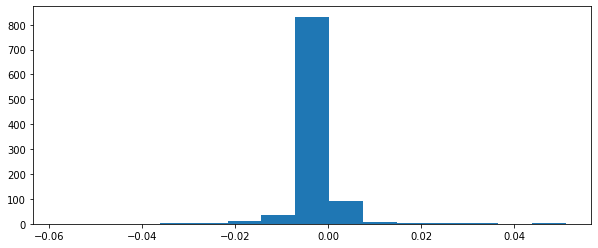

In [17]:
class_idx = 8
#score_list = memory_buffer.meta_score[class_idx, ..., 0]
# Remove the support = 0
score_list = memory_buffer.meta_score[class_idx][memory_buffer.meta_score[class_idx, ...,1] != 0]

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

### Plotting Distribution of Scores for one sample

#Scores in ScoreList 200
# Score in sample_idx: 0.0
# Support in sample_idx: 0.0


(array([ 2.,  0.,  5.,  4., 11., 27., 50., 29., 22., 16., 10., 10.,  8.,
         5.,  1.]),
 array([-0.0955258 , -0.07999794, -0.06447009, -0.04894223, -0.03341438,
        -0.01788652, -0.00235866,  0.01316919,  0.02869705,  0.04422491,
         0.05975276,  0.07528062,  0.09080848,  0.10633633,  0.12186419,
         0.13739204]),
 <BarContainer object of 15 artists>)

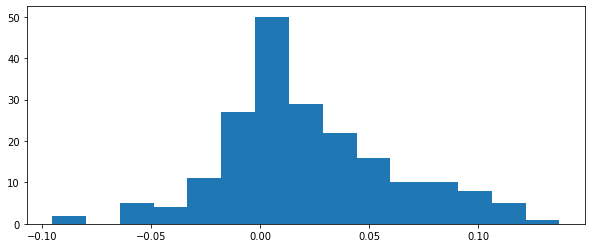

In [24]:
class_idx = 0
sample_idx = 0
score_list = memory_buffer.meta_debug[class_idx][sample_idx]

print(f"#Scores in ScoreList {len(score_list)}")
print(f"# Score in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 0]}")
print(f"# Support in sample_idx: {memory_buffer.meta_score[class_idx, sample_idx, 1]}")

fig, ax =  plt.subplots(figsize=(10,4))
ax.hist(score_list, bins=15)

In [25]:
memory_buffer.meta_debug[class_idx].keys()

dict_keys([0, 5, 10, 15])

# Testing

Select specific column index per row
https://stackoverflow.com/questions/23435782/numpy-selecting-specific-column-index-per-row-by-using-a-list-of-indexes

In [19]:
def evaluate(dataloader, updates, mini_batch_size, dataname=""):
    learner.rln.eval()
    learner.pln.train()
    
    all_losses, all_predictions, all_labels, all_label_conf = [], [], [], []
    all_adaptation_time = []
    # Get Query set first. and then find supporting support set
    for query_idx, (query_text, query_labels) in enumerate(dataloader):
        print(f"Query ID {query_idx}/{len(dataloader)}")
        # The task id to optimize to for support set
        # task_idx = get_task_from_label_list(query_labels, memory_buffer.task_dict)
        task_idx = dataclass_mapper[dataname]
        
    
        support_set = []
        for _ in range(updates):
            text, labels = memory_buffer.read_batch_task(batch_size=mini_batch_size, task_idx=task_idx, sort_score=True)
            support_set.append((text, labels))

        with higher.innerloop_ctx(learner.pln, learner.inner_optimizer,
                                  copy_initial_weights=False, track_higher_grads=False) as (fpln, diffopt):
            
            INNER_tic = time.time()
            # Inner loop
            task_predictions, task_labels = [], []
            support_loss = []
            for text, labels in support_set:
                labels = torch.tensor(labels).to(device)
                input_dict = learner.rln.encode_text(text)
                _repr = learner.rln(input_dict)
                output = fpln(_repr)
                loss = learner.loss_fn(output, labels)
                diffopt.step(loss)
                pred = models.utils.make_prediction(output.detach())
                support_loss.append(loss.item())
                task_predictions.extend(pred.tolist())
                task_labels.extend(labels.tolist())
            INNER_toc = time.time() - INNER_tic
            all_adaptation_time.append(INNER_toc)

            acc, prec, rec, f1 = models.utils.calculate_metrics(task_predictions, task_labels)

            print('Support set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                        'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(support_loss), acc, prec, rec, f1))

            # Query set is now here!
            query_labels = torch.tensor(query_labels).to(device)
            query_input_dict = learner.rln.encode_text(query_text)
            with torch.no_grad():
                query_repr = learner.rln(query_input_dict)
                query_output = fpln(query_repr) # Output has size of torch.Size([16, 33]) [BATCH, CLASSES]
                query_loss = learner.loss_fn(query_output, query_labels)
            query_loss = query_loss.item()
            # print(output.detach().size())
            # output.detach().max(-1) max on each Batch, which will return [0] max, [1] indices
            query_output_softmax = F.softmax(query_output, -1)
            query_label_conf = query_output_softmax[np.arange(len(query_output_softmax)), query_labels] # Select labels in the softmax of 33 classes

            query_pred = models.utils.make_prediction(query_output.detach())
            query_acc, query_prec, query_rec, query_f1 = models.utils.calculate_metrics(query_pred.tolist(), query_labels.tolist())
            
            print('Query set metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, '
                'recall = {:.4f}, F1 score = {:.4f}'.format(np.mean(query_loss), query_acc, query_prec, query_rec, query_f1))

            all_losses.append(query_loss)
            all_predictions.extend(query_pred.tolist())
            all_labels.extend(query_labels.tolist())
            all_label_conf.extend(query_label_conf.tolist())

    acc, prec, rec, f1 = models.utils.calculate_metrics(all_predictions, all_labels)
    print('Test metrics: Loss = {:.4f}, accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
                'F1 score = {:.4f}'.format(np.mean(all_losses), acc, prec, rec, f1))
    return acc, prec, rec, f1, all_predictions, all_labels, all_label_conf, all_adaptation_time

In [20]:
tic = time.time()
print('----------Testing on test set starts here----------')

accuracies, precisions, recalls, f1s = [], [], [], []
all_adapt_time = []
# Data for Visualization: [data_idx, label, label_conf, pred]
data_for_visual = []

for test_dataset in test_datasets:
    print('Testing on {}'.format(test_dataset.__class__.__name__))
    test_dataloader = data.DataLoader(test_dataset, batch_size=mini_batch_size, shuffle=False,
                                      collate_fn=datasets.utils.batch_encode)
    acc, prec, rec, f1, all_pred, all_label, all_label_conf, all_adaptation_time = evaluate(dataloader=test_dataloader, updates=updates, 
                                                mini_batch_size=mini_batch_size, dataname=test_dataset.__class__.__name__)
    
    data_ids = [test_dataset.__class__.__name__ + str(i) for i in range(len(all_label))]
    data_for_visual.extend(list(zip(data_ids, all_label, all_label_conf, all_pred)))
    all_adapt_time.extend(all_adaptation_time)
#     print(data_ids)
#     print(all_label)
#     raise Exception("BREAKPOINT")
    
    accuracies.append(acc)
    precisions.append(prec)
    recalls.append(rec)
    f1s.append(f1)


print()
print("COPY PASTA - not really but ok")
for row in accuracies:
    print(row)
print()
print('Overall test metrics: Accuracy = {:.4f}, precision = {:.4f}, recall = {:.4f}, '
            'F1 score = {:.4f}'.format(np.mean(accuracies), np.mean(precisions), np.mean(recalls), np.mean(f1s)))

toc = time.time() - tic
print(f"Total Time used: {toc//60} minutes")

----------Testing on test set starts here----------
Testing on YelpDataset
Query ID 0/475
Support set metrics: Loss = 0.7501, accuracy = 0.6875, precision = 0.6819, recall = 0.6800, F1 score = 0.6667
Query set metrics: Loss = 0.6170, accuracy = 0.6875, precision = 0.7800, recall = 0.6933, F1 score = 0.6900
Query ID 1/475
Support set metrics: Loss = 0.8970, accuracy = 0.6500, precision = 0.6914, recall = 0.6433, F1 score = 0.6614
Query set metrics: Loss = 0.7036, accuracy = 0.7500, precision = 0.7267, recall = 0.7933, F1 score = 0.7200
Query ID 2/475
Support set metrics: Loss = 0.6380, accuracy = 0.7750, precision = 0.7669, recall = 0.7633, F1 score = 0.7576
Query set metrics: Loss = 0.9838, accuracy = 0.5000, precision = 0.5167, recall = 0.5167, F1 score = 0.5048
Query ID 3/475
Support set metrics: Loss = 0.5999, accuracy = 0.8250, precision = 0.8545, recall = 0.8167, F1 score = 0.8263
Query set metrics: Loss = 0.8735, accuracy = 0.6250, precision = 0.6200, recall = 0.6000, F1 score = 

Support set metrics: Loss = 0.7848, accuracy = 0.6625, precision = 0.6395, recall = 0.6533, F1 score = 0.6320
Query set metrics: Loss = 0.7114, accuracy = 0.6875, precision = 0.7167, recall = 0.7000, F1 score = 0.7040
Query ID 36/475
Support set metrics: Loss = 0.8123, accuracy = 0.6125, precision = 0.6220, recall = 0.6000, F1 score = 0.6061
Query set metrics: Loss = 0.7898, accuracy = 0.7500, precision = 0.7000, recall = 0.7500, F1 score = 0.7048
Query ID 37/475
Support set metrics: Loss = 0.6682, accuracy = 0.7500, precision = 0.7510, recall = 0.7400, F1 score = 0.7421
Query set metrics: Loss = 0.6971, accuracy = 0.7500, precision = 0.6033, recall = 0.6433, F1 score = 0.6111
Query ID 38/475
Support set metrics: Loss = 0.7362, accuracy = 0.7250, precision = 0.7170, recall = 0.7167, F1 score = 0.7058
Query set metrics: Loss = 0.8381, accuracy = 0.6250, precision = 0.5133, recall = 0.6200, F1 score = 0.5578
Query ID 39/475
Support set metrics: Loss = 0.6738, accuracy = 0.7625, precision

Query set metrics: Loss = 1.4134, accuracy = 0.4375, precision = 0.5333, recall = 0.5267, F1 score = 0.4633
Query ID 71/475
Support set metrics: Loss = 0.7325, accuracy = 0.7375, precision = 0.7799, recall = 0.7233, F1 score = 0.7304
Query set metrics: Loss = 0.8107, accuracy = 0.7500, precision = 0.7500, recall = 0.6333, F1 score = 0.6814
Query ID 72/475
Support set metrics: Loss = 0.8595, accuracy = 0.6750, precision = 0.6989, recall = 0.6667, F1 score = 0.6798
Query set metrics: Loss = 0.6627, accuracy = 0.6250, precision = 0.5810, recall = 0.5700, F1 score = 0.5683
Query ID 73/475
Support set metrics: Loss = 0.7689, accuracy = 0.7125, precision = 0.7361, recall = 0.7100, F1 score = 0.7161
Query set metrics: Loss = 0.9101, accuracy = 0.7500, precision = 0.6833, recall = 0.6533, F1 score = 0.6414
Query ID 74/475
Support set metrics: Loss = 0.7764, accuracy = 0.6250, precision = 0.6371, recall = 0.6100, F1 score = 0.6135
Query set metrics: Loss = 0.8945, accuracy = 0.6250, precision =

Query set metrics: Loss = 0.6708, accuracy = 0.7500, precision = 0.7600, recall = 0.7167, F1 score = 0.7235
Query ID 106/475
Support set metrics: Loss = 0.8265, accuracy = 0.6250, precision = 0.6130, recall = 0.6167, F1 score = 0.6119
Query set metrics: Loss = 1.2352, accuracy = 0.3750, precision = 0.3500, recall = 0.4333, F1 score = 0.3705
Query ID 107/475
Support set metrics: Loss = 0.7799, accuracy = 0.7000, precision = 0.7009, recall = 0.6967, F1 score = 0.6923
Query set metrics: Loss = 0.9088, accuracy = 0.5625, precision = 0.6000, recall = 0.5500, F1 score = 0.5467
Query ID 108/475
Support set metrics: Loss = 0.8381, accuracy = 0.6625, precision = 0.6878, recall = 0.6500, F1 score = 0.6504
Query set metrics: Loss = 1.1686, accuracy = 0.3750, precision = 0.3524, recall = 0.3300, F1 score = 0.2914
Query ID 109/475
Support set metrics: Loss = 0.7272, accuracy = 0.6750, precision = 0.6826, recall = 0.6633, F1 score = 0.6650
Query set metrics: Loss = 1.0069, accuracy = 0.3750, precisi

Query set metrics: Loss = 0.4635, accuracy = 0.8750, precision = 0.8933, recall = 0.8933, F1 score = 0.8800
Query ID 141/475
Support set metrics: Loss = 0.6584, accuracy = 0.7250, precision = 0.7413, recall = 0.7133, F1 score = 0.7202
Query set metrics: Loss = 0.8206, accuracy = 0.5625, precision = 0.4500, recall = 0.5000, F1 score = 0.4516
Query ID 142/475
Support set metrics: Loss = 0.7761, accuracy = 0.6625, precision = 0.6733, recall = 0.6533, F1 score = 0.6609
Query set metrics: Loss = 0.7219, accuracy = 0.8750, precision = 0.9100, recall = 0.8500, F1 score = 0.8611
Query ID 143/475
Support set metrics: Loss = 0.8284, accuracy = 0.6875, precision = 0.6961, recall = 0.6833, F1 score = 0.6873
Query set metrics: Loss = 0.6018, accuracy = 0.6875, precision = 0.6667, recall = 0.6333, F1 score = 0.6361
Query ID 144/475
Support set metrics: Loss = 0.8028, accuracy = 0.6625, precision = 0.6512, recall = 0.6533, F1 score = 0.6509
Query set metrics: Loss = 0.9626, accuracy = 0.6250, precisi

Query set metrics: Loss = 0.8831, accuracy = 0.5000, precision = 0.4333, recall = 0.4267, F1 score = 0.4233
Query ID 176/475
Support set metrics: Loss = 0.6956, accuracy = 0.7500, precision = 0.7624, recall = 0.7367, F1 score = 0.7463
Query set metrics: Loss = 1.0212, accuracy = 0.4375, precision = 0.4967, recall = 0.4000, F1 score = 0.4071
Query ID 177/475
Support set metrics: Loss = 0.6875, accuracy = 0.7625, precision = 0.7681, recall = 0.7567, F1 score = 0.7601
Query set metrics: Loss = 0.7194, accuracy = 0.6250, precision = 0.7917, recall = 0.7333, F1 score = 0.6792
Query ID 178/475
Support set metrics: Loss = 0.7629, accuracy = 0.6875, precision = 0.6879, recall = 0.6733, F1 score = 0.6711
Query set metrics: Loss = 1.1471, accuracy = 0.5625, precision = 0.5095, recall = 0.5667, F1 score = 0.5333
Query ID 179/475
Support set metrics: Loss = 0.7798, accuracy = 0.6750, precision = 0.6895, recall = 0.6733, F1 score = 0.6787
Query set metrics: Loss = 0.8635, accuracy = 0.4375, precisi

Query set metrics: Loss = 1.1970, accuracy = 0.5625, precision = 0.6667, recall = 0.5833, F1 score = 0.5533
Query ID 211/475
Support set metrics: Loss = 0.8207, accuracy = 0.6750, precision = 0.6779, recall = 0.6633, F1 score = 0.6632
Query set metrics: Loss = 1.0276, accuracy = 0.5000, precision = 0.7389, recall = 0.5667, F1 score = 0.4631
Query ID 212/475
Support set metrics: Loss = 0.7623, accuracy = 0.7000, precision = 0.7042, recall = 0.7033, F1 score = 0.7013
Query set metrics: Loss = 0.8393, accuracy = 0.5625, precision = 0.7133, recall = 0.6000, F1 score = 0.5619
Query ID 213/475
Support set metrics: Loss = 0.7325, accuracy = 0.6500, precision = 0.6501, recall = 0.6400, F1 score = 0.6431
Query set metrics: Loss = 0.6758, accuracy = 0.7500, precision = 0.5800, recall = 0.6167, F1 score = 0.5657
Query ID 214/475
Support set metrics: Loss = 0.7772, accuracy = 0.7000, precision = 0.7121, recall = 0.7033, F1 score = 0.7065
Query set metrics: Loss = 1.0281, accuracy = 0.5000, precisi

Support set metrics: Loss = 0.6836, accuracy = 0.7875, precision = 0.7900, recall = 0.7800, F1 score = 0.7809
Query set metrics: Loss = 0.8907, accuracy = 0.6250, precision = 0.6333, recall = 0.6500, F1 score = 0.6181
Query ID 247/475
Support set metrics: Loss = 0.7221, accuracy = 0.6500, precision = 0.6573, recall = 0.6400, F1 score = 0.6431
Query set metrics: Loss = 1.1032, accuracy = 0.7500, precision = 0.8000, recall = 0.7700, F1 score = 0.7381
Query ID 248/475
Support set metrics: Loss = 0.7653, accuracy = 0.6500, precision = 0.6707, recall = 0.6400, F1 score = 0.6477
Query set metrics: Loss = 0.8130, accuracy = 0.6875, precision = 0.7600, recall = 0.7000, F1 score = 0.6978
Query ID 249/475
Support set metrics: Loss = 0.6924, accuracy = 0.7125, precision = 0.7155, recall = 0.7033, F1 score = 0.7086
Query set metrics: Loss = 0.9343, accuracy = 0.6875, precision = 0.8000, recall = 0.7810, F1 score = 0.7121
Query ID 250/475
Support set metrics: Loss = 0.7051, accuracy = 0.7875, preci

Support set metrics: Loss = 0.7177, accuracy = 0.7000, precision = 0.6964, recall = 0.6900, F1 score = 0.6861
Query set metrics: Loss = 0.8435, accuracy = 0.6250, precision = 0.6333, recall = 0.7600, F1 score = 0.6333
Query ID 282/475
Support set metrics: Loss = 0.6892, accuracy = 0.7000, precision = 0.6975, recall = 0.6967, F1 score = 0.6861
Query set metrics: Loss = 0.9961, accuracy = 0.5625, precision = 0.5500, recall = 0.6500, F1 score = 0.5524
Query ID 283/475
Support set metrics: Loss = 0.6588, accuracy = 0.7250, precision = 0.7339, recall = 0.7200, F1 score = 0.7256
Query set metrics: Loss = 1.0329, accuracy = 0.5625, precision = 0.6300, recall = 0.5500, F1 score = 0.5522
Query ID 284/475
Support set metrics: Loss = 0.6924, accuracy = 0.8125, precision = 0.8545, recall = 0.8033, F1 score = 0.8211
Query set metrics: Loss = 0.6166, accuracy = 0.6250, precision = 0.7133, recall = 0.7143, F1 score = 0.6564
Query ID 285/475
Support set metrics: Loss = 0.6729, accuracy = 0.7250, preci

Support set metrics: Loss = 0.7203, accuracy = 0.6750, precision = 0.6756, recall = 0.6700, F1 score = 0.6620
Query set metrics: Loss = 0.6001, accuracy = 0.6875, precision = 0.6333, recall = 0.6333, F1 score = 0.6276
Query ID 317/475
Support set metrics: Loss = 0.6474, accuracy = 0.7375, precision = 0.7233, recall = 0.7233, F1 score = 0.7133
Query set metrics: Loss = 0.8985, accuracy = 0.6250, precision = 0.6667, recall = 0.5933, F1 score = 0.5711
Query ID 318/475
Support set metrics: Loss = 0.8259, accuracy = 0.6375, precision = 0.6425, recall = 0.6233, F1 score = 0.6267
Query set metrics: Loss = 0.9883, accuracy = 0.5625, precision = 0.5500, recall = 0.6000, F1 score = 0.5048
Query ID 319/475
Support set metrics: Loss = 0.7733, accuracy = 0.7375, precision = 0.7393, recall = 0.7367, F1 score = 0.7357
Query set metrics: Loss = 0.9853, accuracy = 0.6250, precision = 0.6033, recall = 0.6333, F1 score = 0.6000
Query ID 320/475
Support set metrics: Loss = 0.6821, accuracy = 0.7750, preci

Support set metrics: Loss = 0.8248, accuracy = 0.6625, precision = 0.6729, recall = 0.6467, F1 score = 0.6570
Query set metrics: Loss = 1.1659, accuracy = 0.5625, precision = 0.6500, recall = 0.5524, F1 score = 0.5771
Query ID 352/475
Support set metrics: Loss = 0.7764, accuracy = 0.6750, precision = 0.6853, recall = 0.6700, F1 score = 0.6682
Query set metrics: Loss = 0.7492, accuracy = 0.8125, precision = 0.8083, recall = 0.8000, F1 score = 0.7467
Query ID 353/475
Support set metrics: Loss = 0.7030, accuracy = 0.7375, precision = 0.7390, recall = 0.7333, F1 score = 0.7346
Query set metrics: Loss = 1.3672, accuracy = 0.3750, precision = 0.4300, recall = 0.2667, F1 score = 0.3089
Query ID 354/475
Support set metrics: Loss = 0.7719, accuracy = 0.6750, precision = 0.6708, recall = 0.6700, F1 score = 0.6684
Query set metrics: Loss = 0.8335, accuracy = 0.7500, precision = 0.7533, recall = 0.7600, F1 score = 0.7187
Query ID 355/475
Support set metrics: Loss = 0.7823, accuracy = 0.6125, preci

Support set metrics: Loss = 0.8231, accuracy = 0.6500, precision = 0.6482, recall = 0.6367, F1 score = 0.6352
Query set metrics: Loss = 1.0493, accuracy = 0.5000, precision = 0.5967, recall = 0.5467, F1 score = 0.5048
Query ID 387/475
Support set metrics: Loss = 0.7342, accuracy = 0.7250, precision = 0.7484, recall = 0.7200, F1 score = 0.7261
Query set metrics: Loss = 1.4033, accuracy = 0.6250, precision = 0.5167, recall = 0.5095, F1 score = 0.4981
Query ID 388/475
Support set metrics: Loss = 0.7927, accuracy = 0.6375, precision = 0.6453, recall = 0.6267, F1 score = 0.6302
Query set metrics: Loss = 0.5644, accuracy = 0.8750, precision = 0.8933, recall = 0.8833, F1 score = 0.8692
Query ID 389/475
Support set metrics: Loss = 0.7472, accuracy = 0.6750, precision = 0.6656, recall = 0.6700, F1 score = 0.6640
Query set metrics: Loss = 0.9275, accuracy = 0.5000, precision = 0.5000, recall = 0.6333, F1 score = 0.5014
Query ID 390/475
Support set metrics: Loss = 0.7512, accuracy = 0.7500, preci

Support set metrics: Loss = 0.7280, accuracy = 0.7000, precision = 0.6922, recall = 0.6933, F1 score = 0.6862
Query set metrics: Loss = 1.2040, accuracy = 0.3125, precision = 0.1667, recall = 0.3500, F1 score = 0.2200
Query ID 422/475
Support set metrics: Loss = 0.9102, accuracy = 0.6125, precision = 0.6173, recall = 0.6067, F1 score = 0.6075
Query set metrics: Loss = 1.1762, accuracy = 0.6250, precision = 0.7167, recall = 0.7200, F1 score = 0.7105
Query ID 423/475
Support set metrics: Loss = 0.8580, accuracy = 0.6250, precision = 0.6216, recall = 0.6200, F1 score = 0.6190
Query set metrics: Loss = 0.9131, accuracy = 0.5625, precision = 0.5667, recall = 0.6167, F1 score = 0.5733
Query ID 424/475
Support set metrics: Loss = 0.7134, accuracy = 0.7000, precision = 0.7049, recall = 0.6933, F1 score = 0.6957
Query set metrics: Loss = 0.9310, accuracy = 0.5625, precision = 0.6875, recall = 0.6250, F1 score = 0.6528
Query ID 425/475
Support set metrics: Loss = 0.5604, accuracy = 0.8250, preci

Support set metrics: Loss = 0.6608, accuracy = 0.7625, precision = 0.7722, recall = 0.7533, F1 score = 0.7553
Query set metrics: Loss = 1.2144, accuracy = 0.6875, precision = 0.8000, recall = 0.6333, F1 score = 0.6885
Query ID 457/475
Support set metrics: Loss = 0.6650, accuracy = 0.7500, precision = 0.7345, recall = 0.7400, F1 score = 0.7226
Query set metrics: Loss = 0.5263, accuracy = 0.8125, precision = 0.8533, recall = 0.8333, F1 score = 0.8381
Query ID 458/475
Support set metrics: Loss = 0.9006, accuracy = 0.6250, precision = 0.6457, recall = 0.6100, F1 score = 0.6247
Query set metrics: Loss = 1.3026, accuracy = 0.6250, precision = 0.5667, recall = 0.6629, F1 score = 0.5672
Query ID 459/475
Support set metrics: Loss = 0.8240, accuracy = 0.6750, precision = 0.6699, recall = 0.6633, F1 score = 0.6608
Query set metrics: Loss = 0.6100, accuracy = 0.7500, precision = 0.7881, recall = 0.7500, F1 score = 0.6694
Query ID 460/475
Support set metrics: Loss = 0.7602, accuracy = 0.7250, preci

Support set metrics: Loss = 0.1475, accuracy = 0.9875, precision = 0.9881, recall = 0.9875, F1 score = 0.9875
Query set metrics: Loss = 0.0612, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 17/475
Support set metrics: Loss = 0.0816, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.3165, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8740
Query ID 18/475
Support set metrics: Loss = 0.1024, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9623
Query set metrics: Loss = 0.3771, accuracy = 0.8750, precision = 0.9286, recall = 0.9167, F1 score = 0.9083
Query ID 19/475
Support set metrics: Loss = 0.2979, accuracy = 0.9500, precision = 0.9555, recall = 0.9500, F1 score = 0.9498
Query set metrics: Loss = 0.5457, accuracy = 0.8125, precision = 0.8250, recall = 0.8021, F1 score = 0.7472
Query ID 20/475
Support set metrics: Loss = 0.2306, accuracy = 0.9500, precision

Support set metrics: Loss = 0.1894, accuracy = 0.9500, precision = 0.9555, recall = 0.9500, F1 score = 0.9498
Query set metrics: Loss = 0.1263, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 53/475
Support set metrics: Loss = 0.1086, accuracy = 0.9750, precision = 0.9773, recall = 0.9750, F1 score = 0.9753
Query set metrics: Loss = 0.0428, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 54/475
Support set metrics: Loss = 0.2751, accuracy = 0.9375, precision = 0.9424, recall = 0.9375, F1 score = 0.9380
Query set metrics: Loss = 0.3794, accuracy = 0.8750, precision = 0.6250, recall = 0.6667, F1 score = 0.6439
Query ID 55/475
Support set metrics: Loss = 0.0622, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0542, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 56/475
Support set metrics: Loss = 0.1612, accuracy = 0.9750, precision

Support set metrics: Loss = 0.1627, accuracy = 0.9625, precision = 0.9648, recall = 0.9625, F1 score = 0.9628
Query set metrics: Loss = 0.2060, accuracy = 0.9375, precision = 0.8750, recall = 0.9500, F1 score = 0.8889
Query ID 89/475
Support set metrics: Loss = 0.1640, accuracy = 0.9750, precision = 0.9756, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.0676, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 90/475
Support set metrics: Loss = 0.0719, accuracy = 0.9875, precision = 0.9881, recall = 0.9875, F1 score = 0.9875
Query set metrics: Loss = 0.2250, accuracy = 0.8750, precision = 0.8875, recall = 0.8750, F1 score = 0.8532
Query ID 91/475
Support set metrics: Loss = 0.0484, accuracy = 0.9875, precision = 0.9881, recall = 0.9875, F1 score = 0.9875
Query set metrics: Loss = 0.0860, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 92/475
Support set metrics: Loss = 0.1024, accuracy = 0.9625, precision

Support set metrics: Loss = 0.1602, accuracy = 0.9625, precision = 0.9654, recall = 0.9625, F1 score = 0.9624
Query set metrics: Loss = 0.0677, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 124/475
Support set metrics: Loss = 0.1505, accuracy = 0.9750, precision = 0.9756, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.2525, accuracy = 0.8125, precision = 0.9167, recall = 0.7500, F1 score = 0.7750
Query ID 125/475
Support set metrics: Loss = 0.1298, accuracy = 0.9500, precision = 0.9583, recall = 0.9500, F1 score = 0.9506
Query set metrics: Loss = 0.4871, accuracy = 0.8750, precision = 0.9444, recall = 0.8750, F1 score = 0.8854
Query ID 126/475
Support set metrics: Loss = 0.1919, accuracy = 0.9500, precision = 0.9549, recall = 0.9500, F1 score = 0.9505
Query set metrics: Loss = 0.2480, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 127/475
Support set metrics: Loss = 0.0690, accuracy = 0.9875, preci

Support set metrics: Loss = 0.1293, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.2029, accuracy = 0.9375, precision = 0.9643, recall = 0.9167, F1 score = 0.9308
Query ID 159/475
Support set metrics: Loss = 0.1210, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.0518, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 160/475
Support set metrics: Loss = 0.0922, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.1921, accuracy = 0.8750, precision = 0.8333, recall = 0.9167, F1 score = 0.8250
Query ID 161/475
Support set metrics: Loss = 0.0700, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.3073, accuracy = 0.8750, precision = 0.9286, recall = 0.8810, F1 score = 0.8891
Query ID 162/475
Support set metrics: Loss = 0.1999, accuracy = 0.9375, preci

Support set metrics: Loss = 0.0605, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.1740, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 194/475
Support set metrics: Loss = 0.2554, accuracy = 0.9375, precision = 0.9436, recall = 0.9375, F1 score = 0.9379
Query set metrics: Loss = 0.1185, accuracy = 0.9375, precision = 0.9500, recall = 0.9583, F1 score = 0.9495
Query ID 195/475
Support set metrics: Loss = 0.0796, accuracy = 0.9875, precision = 0.9881, recall = 0.9875, F1 score = 0.9875
Query set metrics: Loss = 0.2893, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 196/475
Support set metrics: Loss = 0.1315, accuracy = 0.9500, precision = 0.9583, recall = 0.9500, F1 score = 0.9510
Query set metrics: Loss = 0.0650, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 197/475
Support set metrics: Loss = 0.0658, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0979, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9623
Query set metrics: Loss = 0.0595, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 229/475
Support set metrics: Loss = 0.0664, accuracy = 0.9875, precision = 0.9881, recall = 0.9875, F1 score = 0.9875
Query set metrics: Loss = 0.0299, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 230/475
Support set metrics: Loss = 0.0816, accuracy = 0.9750, precision = 0.9773, recall = 0.9750, F1 score = 0.9753
Query set metrics: Loss = 0.1658, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 231/475
Support set metrics: Loss = 0.0876, accuracy = 0.9750, precision = 0.9773, recall = 0.9750, F1 score = 0.9753
Query set metrics: Loss = 0.3320, accuracy = 0.8750, precision = 0.8875, recall = 0.8393, F1 score = 0.8339
Query ID 232/475
Support set metrics: Loss = 0.1196, accuracy = 0.9500, preci

Support set metrics: Loss = 0.1464, accuracy = 0.9875, precision = 0.9881, recall = 0.9875, F1 score = 0.9875
Query set metrics: Loss = 0.2155, accuracy = 0.9375, precision = 0.9583, recall = 0.9167, F1 score = 0.9273
Query ID 264/475
Support set metrics: Loss = 0.0426, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.2561, accuracy = 0.8750, precision = 0.8750, recall = 0.8810, F1 score = 0.8474
Query ID 265/475
Support set metrics: Loss = 0.0956, accuracy = 0.9750, precision = 0.9773, recall = 0.9750, F1 score = 0.9753
Query set metrics: Loss = 0.2353, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 266/475
Support set metrics: Loss = 0.1625, accuracy = 0.9750, precision = 0.9756, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.4249, accuracy = 0.8125, precision = 0.8333, recall = 0.8375, F1 score = 0.8183
Query ID 267/475
Support set metrics: Loss = 0.1640, accuracy = 0.9750, preci

Support set metrics: Loss = 0.2070, accuracy = 0.9250, precision = 0.9361, recall = 0.9250, F1 score = 0.9263
Query set metrics: Loss = 0.2239, accuracy = 0.8750, precision = 0.6518, recall = 0.7143, F1 score = 0.6786
Query ID 299/475
Support set metrics: Loss = 0.1554, accuracy = 0.9625, precision = 0.9641, recall = 0.9625, F1 score = 0.9625
Query set metrics: Loss = 0.2295, accuracy = 0.9375, precision = 0.9500, recall = 0.9583, F1 score = 0.9495
Query ID 300/475
Support set metrics: Loss = 0.1716, accuracy = 0.9500, precision = 0.9549, recall = 0.9500, F1 score = 0.9505
Query set metrics: Loss = 0.3208, accuracy = 0.8750, precision = 0.8854, recall = 0.8333, F1 score = 0.8500
Query ID 301/475
Support set metrics: Loss = 0.1507, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9623
Query set metrics: Loss = 0.1412, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 302/475
Support set metrics: Loss = 0.0863, accuracy = 0.9625, preci

Support set metrics: Loss = 0.1545, accuracy = 0.9625, precision = 0.9648, recall = 0.9625, F1 score = 0.9628
Query set metrics: Loss = 0.0754, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 334/475
Support set metrics: Loss = 0.1546, accuracy = 0.9625, precision = 0.9648, recall = 0.9625, F1 score = 0.9628
Query set metrics: Loss = 0.1239, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9444
Query ID 335/475
Support set metrics: Loss = 0.1022, accuracy = 0.9875, precision = 0.9881, recall = 0.9875, F1 score = 0.9875
Query set metrics: Loss = 0.4443, accuracy = 0.9375, precision = 0.8750, recall = 0.9643, F1 score = 0.8974
Query ID 336/475
Support set metrics: Loss = 0.1511, accuracy = 0.9750, precision = 0.9762, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.4340, accuracy = 0.9375, precision = 0.9722, recall = 0.8750, F1 score = 0.9020
Query ID 337/475
Support set metrics: Loss = 0.1814, accuracy = 0.9500, preci

Support set metrics: Loss = 0.1124, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.2490, accuracy = 0.9375, precision = 0.9583, recall = 0.8750, F1 score = 0.8939
Query ID 369/475
Support set metrics: Loss = 0.1052, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.2437, accuracy = 0.9375, precision = 0.9167, recall = 0.9583, F1 score = 0.9273
Query ID 370/475
Support set metrics: Loss = 0.1830, accuracy = 0.9500, precision = 0.9542, recall = 0.9500, F1 score = 0.9505
Query set metrics: Loss = 0.0406, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 371/475
Support set metrics: Loss = 0.0847, accuracy = 0.9875, precision = 0.9881, recall = 0.9875, F1 score = 0.9875
Query set metrics: Loss = 0.6020, accuracy = 0.7500, precision = 0.7810, recall = 0.6935, F1 score = 0.7143
Query ID 372/475
Support set metrics: Loss = 0.1801, accuracy = 0.9625, preci

Support set metrics: Loss = 0.1761, accuracy = 0.9625, precision = 0.9648, recall = 0.9625, F1 score = 0.9628
Query set metrics: Loss = 0.4679, accuracy = 0.8125, precision = 0.9000, recall = 0.8375, F1 score = 0.8542
Query ID 404/475
Support set metrics: Loss = 0.1003, accuracy = 0.9750, precision = 0.9773, recall = 0.9750, F1 score = 0.9753
Query set metrics: Loss = 0.3513, accuracy = 0.8750, precision = 0.9375, recall = 0.9000, F1 score = 0.9018
Query ID 405/475
Support set metrics: Loss = 0.1127, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.0973, accuracy = 0.9375, precision = 1.0000, recall = 0.8333, F1 score = 0.8889
Query ID 406/475
Support set metrics: Loss = 0.0535, accuracy = 0.9875, precision = 0.9881, recall = 0.9875, F1 score = 0.9875
Query set metrics: Loss = 0.9824, accuracy = 0.6250, precision = 0.6500, recall = 0.6667, F1 score = 0.5958
Query ID 407/475
Support set metrics: Loss = 0.1110, accuracy = 0.9625, preci

Support set metrics: Loss = 0.1458, accuracy = 0.9750, precision = 0.9762, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.1378, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 439/475
Support set metrics: Loss = 0.2703, accuracy = 0.9125, precision = 0.9250, recall = 0.9125, F1 score = 0.9138
Query set metrics: Loss = 0.3984, accuracy = 0.8750, precision = 0.8250, recall = 0.8250, F1 score = 0.8250
Query ID 440/475
Support set metrics: Loss = 0.1163, accuracy = 0.9625, precision = 0.9674, recall = 0.9625, F1 score = 0.9630
Query set metrics: Loss = 0.2133, accuracy = 0.9375, precision = 0.9167, recall = 0.9500, F1 score = 0.9222
Query ID 441/475
Support set metrics: Loss = 0.0881, accuracy = 0.9750, precision = 0.9773, recall = 0.9750, F1 score = 0.9749
Query set metrics: Loss = 0.1114, accuracy = 0.9375, precision = 0.9375, recall = 0.9500, F1 score = 0.9365
Query ID 442/475
Support set metrics: Loss = 0.2258, accuracy = 0.9625, preci

Support set metrics: Loss = 0.1021, accuracy = 0.9750, precision = 0.9773, recall = 0.9750, F1 score = 0.9749
Query set metrics: Loss = 0.0608, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 474/475
Support set metrics: Loss = 0.1536, accuracy = 0.9750, precision = 0.9756, recall = 0.9750, F1 score = 0.9750
Query set metrics: Loss = 0.0676, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Test metrics: Loss = 0.2590, accuracy = 0.9143, precision = 0.9189, recall = 0.9143, F1 score = 0.9158
Testing on DBPediaDataset
Query ID 0/475
Support set metrics: Loss = 0.0093, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0054, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 1/475
Support set metrics: Loss = 0.0449, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precisi

Support set metrics: Loss = 0.0125, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 34/475
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0041, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 35/475
Support set metrics: Loss = 0.0524, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0143, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 36/475
Support set metrics: Loss = 0.0497, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.4394, accuracy = 0.9375, precision = 0.9500, recall = 0.9500, F1 score = 0.9333
Query ID 37/475
Support set metrics: Loss = 0.0103, accuracy = 1.0000, precision

Support set metrics: Loss = 0.0780, accuracy = 0.9750, precision = 0.9796, recall = 0.9857, F1 score = 0.9802
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 70/475
Support set metrics: Loss = 0.0490, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.4678, accuracy = 0.9375, precision = 0.8889, recall = 0.8889, F1 score = 0.8889
Query ID 71/475
Support set metrics: Loss = 0.0445, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0502, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 72/475
Support set metrics: Loss = 0.0511, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 73/475
Support set metrics: Loss = 0.0115, accuracy = 1.0000, precision

Support set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 105/475
Support set metrics: Loss = 0.0509, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0063, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 106/475
Support set metrics: Loss = 0.0429, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.2030, accuracy = 0.9375, precision = 0.9500, recall = 0.9800, F1 score = 0.9556
Query ID 107/475
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0511, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 108/475
Support set metrics: Loss = 0.0817, accuracy = 0.9750, preci

Support set metrics: Loss = 0.0784, accuracy = 0.9750, precision = 0.9796, recall = 0.9857, F1 score = 0.9802
Query set metrics: Loss = 0.0148, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 140/475
Support set metrics: Loss = 0.0115, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0824, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 141/475
Support set metrics: Loss = 0.0469, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0106, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 142/475
Support set metrics: Loss = 0.0468, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0059, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 143/475
Support set metrics: Loss = 0.0790, accuracy = 0.9750, preci

Support set metrics: Loss = 0.0142, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0045, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 175/475
Support set metrics: Loss = 0.0116, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 176/475
Support set metrics: Loss = 0.0455, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0288, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 177/475
Support set metrics: Loss = 0.0124, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 178/475
Support set metrics: Loss = 0.0441, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0812, accuracy = 0.9750, precision = 0.9796, recall = 0.9857, F1 score = 0.9802
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 210/475
Support set metrics: Loss = 0.0481, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0040, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 211/475
Support set metrics: Loss = 0.0819, accuracy = 0.9750, precision = 0.9796, recall = 0.9857, F1 score = 0.9802
Query set metrics: Loss = 0.1508, accuracy = 0.9375, precision = 0.8636, recall = 0.9091, F1 score = 0.8788
Query ID 212/475
Support set metrics: Loss = 0.0456, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 213/475
Support set metrics: Loss = 0.0771, accuracy = 0.9750, preci

Support set metrics: Loss = 0.0078, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.3464, accuracy = 0.9375, precision = 0.9545, recall = 0.9773, F1 score = 0.9567
Query ID 245/475
Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 246/475
Support set metrics: Loss = 0.0089, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0047, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 247/475
Support set metrics: Loss = 0.0109, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0086, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 248/475
Support set metrics: Loss = 0.1399, accuracy = 0.9500, preci

Support set metrics: Loss = 0.0070, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0053, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 280/475
Support set metrics: Loss = 0.0077, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 281/475
Support set metrics: Loss = 0.0499, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 282/475
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 283/475
Support set metrics: Loss = 0.0100, accuracy = 1.0000, preci

Support set metrics: Loss = 0.0789, accuracy = 0.9750, precision = 0.9796, recall = 0.9857, F1 score = 0.9802
Query set metrics: Loss = 0.0064, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 315/475
Support set metrics: Loss = 0.0454, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0060, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 316/475
Support set metrics: Loss = 0.0477, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0046, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 317/475
Support set metrics: Loss = 0.0072, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 318/475
Support set metrics: Loss = 0.0083, accuracy = 1.0000, preci

Support set metrics: Loss = 0.0437, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.1333, accuracy = 0.9375, precision = 0.9545, recall = 0.9697, F1 score = 0.9515
Query ID 350/475
Support set metrics: Loss = 0.0084, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 351/475
Support set metrics: Loss = 0.0157, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0126, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 352/475
Support set metrics: Loss = 0.0489, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 353/475
Support set metrics: Loss = 0.0466, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0471, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 385/475
Support set metrics: Loss = 0.0476, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0122, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 386/475
Support set metrics: Loss = 0.0081, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 387/475
Support set metrics: Loss = 0.0773, accuracy = 0.9750, precision = 0.9796, recall = 0.9857, F1 score = 0.9802
Query set metrics: Loss = 0.0038, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 388/475
Support set metrics: Loss = 0.0473, accuracy = 0.9875, preci

Support set metrics: Loss = 0.0439, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0051, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 420/475
Support set metrics: Loss = 0.0195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0052, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 421/475
Support set metrics: Loss = 0.0071, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0058, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 422/475
Support set metrics: Loss = 0.0061, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.3489, accuracy = 0.9375, precision = 1.0000, recall = 0.9750, F1 score = 0.9857
Query ID 423/475
Support set metrics: Loss = 0.0771, accuracy = 0.9750, preci

Support set metrics: Loss = 0.0508, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0050, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 455/475
Support set metrics: Loss = 0.0473, accuracy = 0.9875, precision = 0.9881, recall = 0.9929, F1 score = 0.9897
Query set metrics: Loss = 0.0055, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 456/475
Support set metrics: Loss = 0.0082, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.1641, accuracy = 0.9375, precision = 0.9500, recall = 0.9750, F1 score = 0.9524
Query ID 457/475
Support set metrics: Loss = 0.0195, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query set metrics: Loss = 0.0328, accuracy = 1.0000, precision = 1.0000, recall = 1.0000, F1 score = 1.0000
Query ID 458/475
Support set metrics: Loss = 0.0445, accuracy = 0.9875, preci

Support set metrics: Loss = 0.7324, accuracy = 0.7000, precision = 0.7088, recall = 0.6933, F1 score = 0.6966
Query set metrics: Loss = 0.8712, accuracy = 0.6875, precision = 0.6167, recall = 0.6214, F1 score = 0.5360
Query ID 15/475
Support set metrics: Loss = 0.7675, accuracy = 0.7250, precision = 0.7391, recall = 0.7200, F1 score = 0.7255
Query set metrics: Loss = 1.2183, accuracy = 0.5000, precision = 0.4933, recall = 0.5800, F1 score = 0.4571
Query ID 16/475
Support set metrics: Loss = 0.7279, accuracy = 0.7250, precision = 0.7149, recall = 0.7233, F1 score = 0.7181
Query set metrics: Loss = 0.6348, accuracy = 0.7500, precision = 0.7333, recall = 0.6667, F1 score = 0.6600
Query ID 17/475
Support set metrics: Loss = 0.6737, accuracy = 0.7625, precision = 0.7677, recall = 0.7633, F1 score = 0.7629
Query set metrics: Loss = 1.0346, accuracy = 0.5000, precision = 0.5667, recall = 0.4810, F1 score = 0.4967
Query ID 18/475
Support set metrics: Loss = 0.7899, accuracy = 0.6875, precision

Support set metrics: Loss = 0.8101, accuracy = 0.6125, precision = 0.6325, recall = 0.6000, F1 score = 0.6107
Query set metrics: Loss = 0.7641, accuracy = 0.6875, precision = 0.6333, recall = 0.6333, F1 score = 0.5867
Query ID 51/475
Support set metrics: Loss = 0.7867, accuracy = 0.6875, precision = 0.6836, recall = 0.6767, F1 score = 0.6788
Query set metrics: Loss = 0.9030, accuracy = 0.6250, precision = 0.5857, recall = 0.6500, F1 score = 0.5333
Query ID 52/475
Support set metrics: Loss = 0.8468, accuracy = 0.6125, precision = 0.6282, recall = 0.6067, F1 score = 0.6150
Query set metrics: Loss = 0.6428, accuracy = 0.6875, precision = 0.7367, recall = 0.7000, F1 score = 0.6690
Query ID 53/475
Support set metrics: Loss = 0.7889, accuracy = 0.7250, precision = 0.7418, recall = 0.7267, F1 score = 0.7313
Query set metrics: Loss = 0.8920, accuracy = 0.5625, precision = 0.4250, recall = 0.4167, F1 score = 0.4053
Query ID 54/475
Support set metrics: Loss = 0.8027, accuracy = 0.7000, precision

Support set metrics: Loss = 0.8247, accuracy = 0.6750, precision = 0.6957, recall = 0.6700, F1 score = 0.6768
Query set metrics: Loss = 0.9288, accuracy = 0.5625, precision = 0.5667, recall = 0.5500, F1 score = 0.5486
Query ID 87/475
Support set metrics: Loss = 0.6524, accuracy = 0.7250, precision = 0.7321, recall = 0.7233, F1 score = 0.7174
Query set metrics: Loss = 1.1040, accuracy = 0.5625, precision = 0.6000, recall = 0.5200, F1 score = 0.4857
Query ID 88/475
Support set metrics: Loss = 0.6800, accuracy = 0.7625, precision = 0.7578, recall = 0.7600, F1 score = 0.7570
Query set metrics: Loss = 1.3878, accuracy = 0.4375, precision = 0.4400, recall = 0.4810, F1 score = 0.3802
Query ID 89/475
Support set metrics: Loss = 0.6805, accuracy = 0.6875, precision = 0.6793, recall = 0.6800, F1 score = 0.6699
Query set metrics: Loss = 1.0637, accuracy = 0.5625, precision = 0.5786, recall = 0.6500, F1 score = 0.5262
Query ID 90/475
Support set metrics: Loss = 0.8201, accuracy = 0.6750, precision

Support set metrics: Loss = 0.7457, accuracy = 0.5875, precision = 0.5946, recall = 0.5767, F1 score = 0.5840
Query set metrics: Loss = 0.9737, accuracy = 0.6250, precision = 0.7457, recall = 0.7067, F1 score = 0.6549
Query ID 122/475
Support set metrics: Loss = 0.6949, accuracy = 0.7250, precision = 0.7366, recall = 0.7133, F1 score = 0.7182
Query set metrics: Loss = 0.8186, accuracy = 0.6875, precision = 0.7500, recall = 0.6101, F1 score = 0.6266
Query ID 123/475
Support set metrics: Loss = 0.8200, accuracy = 0.6250, precision = 0.6098, recall = 0.6100, F1 score = 0.6013
Query set metrics: Loss = 1.1838, accuracy = 0.5000, precision = 0.4833, recall = 0.5467, F1 score = 0.4524
Query ID 124/475
Support set metrics: Loss = 0.7234, accuracy = 0.6875, precision = 0.6929, recall = 0.6900, F1 score = 0.6845
Query set metrics: Loss = 1.5120, accuracy = 0.2500, precision = 0.1357, recall = 0.2167, F1 score = 0.1662
Query ID 125/475
Support set metrics: Loss = 0.6968, accuracy = 0.7000, preci

Support set metrics: Loss = 0.8246, accuracy = 0.6875, precision = 0.7200, recall = 0.6933, F1 score = 0.7038
Query set metrics: Loss = 1.0000, accuracy = 0.3750, precision = 0.3600, recall = 0.5000, F1 score = 0.4071
Query ID 157/475
Support set metrics: Loss = 0.7896, accuracy = 0.7125, precision = 0.7210, recall = 0.7033, F1 score = 0.7092
Query set metrics: Loss = 1.1047, accuracy = 0.5000, precision = 0.4500, recall = 0.4267, F1 score = 0.4349
Query ID 158/475
Support set metrics: Loss = 0.7665, accuracy = 0.7375, precision = 0.7406, recall = 0.7333, F1 score = 0.7365
Query set metrics: Loss = 1.1812, accuracy = 0.5625, precision = 0.6500, recall = 0.6000, F1 score = 0.5822
Query ID 159/475
Support set metrics: Loss = 0.8011, accuracy = 0.6750, precision = 0.6649, recall = 0.6633, F1 score = 0.6603
Query set metrics: Loss = 0.7211, accuracy = 0.6875, precision = 0.7167, recall = 0.7133, F1 score = 0.6788
Query ID 160/475
Support set metrics: Loss = 0.8639, accuracy = 0.6125, preci

Support set metrics: Loss = 0.7408, accuracy = 0.7125, precision = 0.7276, recall = 0.7000, F1 score = 0.7063
Query set metrics: Loss = 1.5484, accuracy = 0.2500, precision = 0.1738, recall = 0.3500, F1 score = 0.2099
Query ID 192/475
Support set metrics: Loss = 0.6092, accuracy = 0.7875, precision = 0.8011, recall = 0.7833, F1 score = 0.7871
Query set metrics: Loss = 1.3638, accuracy = 0.3750, precision = 0.5714, recall = 0.3833, F1 score = 0.4213
Query ID 193/475
Support set metrics: Loss = 0.8535, accuracy = 0.6875, precision = 0.7206, recall = 0.6733, F1 score = 0.6877
Query set metrics: Loss = 0.7531, accuracy = 0.6875, precision = 0.7000, recall = 0.6375, F1 score = 0.6587
Query ID 194/475
Support set metrics: Loss = 0.7394, accuracy = 0.7250, precision = 0.7106, recall = 0.7133, F1 score = 0.7100
Query set metrics: Loss = 1.1845, accuracy = 0.3125, precision = 0.2905, recall = 0.5000, F1 score = 0.2794
Query ID 195/475
Support set metrics: Loss = 0.7399, accuracy = 0.7000, preci

Support set metrics: Loss = 0.6225, accuracy = 0.8500, precision = 0.8602, recall = 0.8433, F1 score = 0.8454
Query set metrics: Loss = 0.8735, accuracy = 0.6250, precision = 0.6917, recall = 0.6042, F1 score = 0.5792
Query ID 227/475
Support set metrics: Loss = 0.7290, accuracy = 0.7125, precision = 0.7250, recall = 0.7100, F1 score = 0.7154
Query set metrics: Loss = 1.1206, accuracy = 0.4375, precision = 0.5667, recall = 0.4333, F1 score = 0.4000
Query ID 228/475
Support set metrics: Loss = 0.7883, accuracy = 0.6875, precision = 0.6844, recall = 0.6733, F1 score = 0.6709
Query set metrics: Loss = 0.7990, accuracy = 0.6875, precision = 0.7167, recall = 0.7200, F1 score = 0.6957
Query ID 229/475
Support set metrics: Loss = 0.6310, accuracy = 0.7625, precision = 0.7648, recall = 0.7567, F1 score = 0.7574
Query set metrics: Loss = 1.2456, accuracy = 0.3750, precision = 0.5133, recall = 0.3400, F1 score = 0.3794
Query ID 230/475
Support set metrics: Loss = 0.6944, accuracy = 0.7125, preci

Support set metrics: Loss = 0.8203, accuracy = 0.7375, precision = 0.7751, recall = 0.7333, F1 score = 0.7443
Query set metrics: Loss = 0.7822, accuracy = 0.5625, precision = 0.6167, recall = 0.5300, F1 score = 0.4561
Query ID 262/475
Support set metrics: Loss = 0.7406, accuracy = 0.7625, precision = 0.7789, recall = 0.7567, F1 score = 0.7619
Query set metrics: Loss = 0.7816, accuracy = 0.6875, precision = 0.6933, recall = 0.6867, F1 score = 0.6521
Query ID 263/475
Support set metrics: Loss = 0.6170, accuracy = 0.7875, precision = 0.7883, recall = 0.7833, F1 score = 0.7734
Query set metrics: Loss = 1.5099, accuracy = 0.5625, precision = 0.6800, recall = 0.5524, F1 score = 0.5778
Query ID 264/475
Support set metrics: Loss = 0.7953, accuracy = 0.6250, precision = 0.6134, recall = 0.6167, F1 score = 0.6116
Query set metrics: Loss = 1.3534, accuracy = 0.3750, precision = 0.3867, recall = 0.2800, F1 score = 0.3048
Query ID 265/475
Support set metrics: Loss = 0.7697, accuracy = 0.6875, preci

Support set metrics: Loss = 0.6995, accuracy = 0.7500, precision = 0.7532, recall = 0.7333, F1 score = 0.7384
Query set metrics: Loss = 0.9739, accuracy = 0.6250, precision = 0.5800, recall = 0.5133, F1 score = 0.5400
Query ID 297/475
Support set metrics: Loss = 0.7448, accuracy = 0.7125, precision = 0.7214, recall = 0.7033, F1 score = 0.7066
Query set metrics: Loss = 0.9957, accuracy = 0.6875, precision = 0.5452, recall = 0.6167, F1 score = 0.5750
Query ID 298/475
Support set metrics: Loss = 0.7887, accuracy = 0.6875, precision = 0.6819, recall = 0.6833, F1 score = 0.6770
Query set metrics: Loss = 0.9994, accuracy = 0.6250, precision = 0.7000, recall = 0.7200, F1 score = 0.6358
Query ID 299/475
Support set metrics: Loss = 0.7445, accuracy = 0.7500, precision = 0.7891, recall = 0.7333, F1 score = 0.7403
Query set metrics: Loss = 0.8076, accuracy = 0.6875, precision = 0.7333, recall = 0.7367, F1 score = 0.7100
Query ID 300/475
Support set metrics: Loss = 0.7111, accuracy = 0.7375, preci

Support set metrics: Loss = 0.7272, accuracy = 0.6875, precision = 0.6825, recall = 0.6833, F1 score = 0.6770
Query set metrics: Loss = 1.0089, accuracy = 0.6875, precision = 0.5273, recall = 0.5750, F1 score = 0.5474
Query ID 332/475
Support set metrics: Loss = 0.7565, accuracy = 0.6750, precision = 0.6748, recall = 0.6700, F1 score = 0.6676
Query set metrics: Loss = 1.1164, accuracy = 0.5625, precision = 0.6633, recall = 0.5833, F1 score = 0.5648
Query ID 333/475
Support set metrics: Loss = 0.7536, accuracy = 0.6875, precision = 0.6953, recall = 0.6767, F1 score = 0.6809
Query set metrics: Loss = 0.8464, accuracy = 0.6250, precision = 0.7000, recall = 0.7000, F1 score = 0.6524
Query ID 334/475
Support set metrics: Loss = 0.7971, accuracy = 0.6625, precision = 0.6655, recall = 0.6633, F1 score = 0.6621
Query set metrics: Loss = 0.8792, accuracy = 0.6875, precision = 0.7600, recall = 0.7000, F1 score = 0.6778
Query ID 335/475
Support set metrics: Loss = 0.6175, accuracy = 0.7250, preci

Support set metrics: Loss = 0.6602, accuracy = 0.7500, precision = 0.7405, recall = 0.7433, F1 score = 0.7377
Query set metrics: Loss = 1.1295, accuracy = 0.5000, precision = 0.4933, recall = 0.4333, F1 score = 0.4521
Query ID 367/475
Support set metrics: Loss = 0.7362, accuracy = 0.7375, precision = 0.7496, recall = 0.7300, F1 score = 0.7325
Query set metrics: Loss = 0.9022, accuracy = 0.7500, precision = 0.8125, recall = 0.7917, F1 score = 0.7946
Query ID 368/475
Support set metrics: Loss = 0.6753, accuracy = 0.8125, precision = 0.8300, recall = 0.8100, F1 score = 0.8188
Query set metrics: Loss = 0.9563, accuracy = 0.5000, precision = 0.5467, recall = 0.5167, F1 score = 0.5038
Query ID 369/475
Support set metrics: Loss = 0.6096, accuracy = 0.7875, precision = 0.7788, recall = 0.7833, F1 score = 0.7760
Query set metrics: Loss = 0.7340, accuracy = 0.6250, precision = 0.7708, recall = 0.5786, F1 score = 0.6417
Query ID 370/475
Support set metrics: Loss = 0.6235, accuracy = 0.7750, preci

Support set metrics: Loss = 0.7907, accuracy = 0.6750, precision = 0.6701, recall = 0.6600, F1 score = 0.6581
Query set metrics: Loss = 1.0398, accuracy = 0.4375, precision = 0.3875, recall = 0.5500, F1 score = 0.4111
Query ID 402/475
Support set metrics: Loss = 0.8737, accuracy = 0.6625, precision = 0.6962, recall = 0.6600, F1 score = 0.6654
Query set metrics: Loss = 1.0792, accuracy = 0.6250, precision = 0.5976, recall = 0.5100, F1 score = 0.5167
Query ID 403/475
Support set metrics: Loss = 0.7529, accuracy = 0.7375, precision = 0.7561, recall = 0.7300, F1 score = 0.7375
Query set metrics: Loss = 1.0313, accuracy = 0.6250, precision = 0.5533, recall = 0.5867, F1 score = 0.5476
Query ID 404/475
Support set metrics: Loss = 0.7142, accuracy = 0.7375, precision = 0.7664, recall = 0.7300, F1 score = 0.7398
Query set metrics: Loss = 0.8173, accuracy = 0.5000, precision = 0.6300, recall = 0.5357, F1 score = 0.5034
Query ID 405/475
Support set metrics: Loss = 0.7745, accuracy = 0.6875, preci

Support set metrics: Loss = 0.7472, accuracy = 0.7250, precision = 0.7213, recall = 0.7133, F1 score = 0.7169
Query set metrics: Loss = 1.0400, accuracy = 0.8125, precision = 0.9333, recall = 0.8333, F1 score = 0.8533
Query ID 437/475
Support set metrics: Loss = 0.7776, accuracy = 0.6500, precision = 0.6649, recall = 0.6433, F1 score = 0.6446
Query set metrics: Loss = 1.0992, accuracy = 0.6250, precision = 0.7500, recall = 0.6367, F1 score = 0.6143
Query ID 438/475
Support set metrics: Loss = 0.7534, accuracy = 0.7250, precision = 0.7330, recall = 0.7167, F1 score = 0.7203
Query set metrics: Loss = 0.8544, accuracy = 0.6875, precision = 0.7000, recall = 0.6667, F1 score = 0.6485
Query ID 439/475
Support set metrics: Loss = 0.7614, accuracy = 0.7375, precision = 0.7306, recall = 0.7300, F1 score = 0.7289
Query set metrics: Loss = 1.0403, accuracy = 0.4375, precision = 0.4233, recall = 0.4800, F1 score = 0.3705
Query ID 440/475
Support set metrics: Loss = 0.7727, accuracy = 0.7250, preci

Support set metrics: Loss = 0.8611, accuracy = 0.6750, precision = 0.6879, recall = 0.6667, F1 score = 0.6692
Query set metrics: Loss = 0.7769, accuracy = 0.7500, precision = 0.8133, recall = 0.7333, F1 score = 0.7476
Query ID 472/475
Support set metrics: Loss = 0.7395, accuracy = 0.7000, precision = 0.7161, recall = 0.6933, F1 score = 0.6999
Query set metrics: Loss = 0.8633, accuracy = 0.6250, precision = 0.7467, recall = 0.6733, F1 score = 0.6076
Query ID 473/475
Support set metrics: Loss = 0.6185, accuracy = 0.8000, precision = 0.7963, recall = 0.7933, F1 score = 0.7917
Query set metrics: Loss = 0.8350, accuracy = 0.6250, precision = 0.6190, recall = 0.5500, F1 score = 0.4933
Query ID 474/475
Support set metrics: Loss = 0.7066, accuracy = 0.7250, precision = 0.7262, recall = 0.7167, F1 score = 0.7207
Query set metrics: Loss = 0.9902, accuracy = 0.5000, precision = 0.4500, recall = 0.4333, F1 score = 0.4300
Test metrics: Loss = 1.0489, accuracy = 0.5603, precision = 0.5788, recall = 

Query set metrics: Loss = 0.8847, accuracy = 0.7500, precision = 0.8750, recall = 0.7708, F1 score = 0.8000
Query ID 31/475
Support set metrics: Loss = 0.9240, accuracy = 0.6875, precision = 0.7111, recall = 0.7000, F1 score = 0.6849
Query set metrics: Loss = 1.1313, accuracy = 0.6875, precision = 0.7917, recall = 0.6875, F1 score = 0.6958
Query ID 32/475
Support set metrics: Loss = 0.9908, accuracy = 0.6625, precision = 0.6689, recall = 0.6600, F1 score = 0.6440
Query set metrics: Loss = 0.9390, accuracy = 0.6250, precision = 0.6574, recall = 0.6852, F1 score = 0.6370
Query ID 33/475
Support set metrics: Loss = 0.8605, accuracy = 0.7375, precision = 0.7532, recall = 0.7300, F1 score = 0.6950
Query set metrics: Loss = 1.5345, accuracy = 0.6250, precision = 0.7083, recall = 0.6250, F1 score = 0.6000
Query ID 34/475
Support set metrics: Loss = 0.9682, accuracy = 0.6500, precision = 0.6483, recall = 0.6400, F1 score = 0.6291
Query set metrics: Loss = 1.0387, accuracy = 0.6875, precision =

Support set metrics: Loss = 1.0257, accuracy = 0.6750, precision = 0.6990, recall = 0.6600, F1 score = 0.6555
Query set metrics: Loss = 0.6709, accuracy = 0.8125, precision = 0.7500, recall = 0.8286, F1 score = 0.7732
Query ID 67/475
Support set metrics: Loss = 0.8786, accuracy = 0.6000, precision = 0.6306, recall = 0.6200, F1 score = 0.5893
Query set metrics: Loss = 1.1864, accuracy = 0.5625, precision = 0.4542, recall = 0.4542, F1 score = 0.4500
Query ID 68/475
Support set metrics: Loss = 0.9244, accuracy = 0.7250, precision = 0.7282, recall = 0.7400, F1 score = 0.7237
Query set metrics: Loss = 0.7285, accuracy = 0.6875, precision = 0.7778, recall = 0.7222, F1 score = 0.7407
Query ID 69/475
Support set metrics: Loss = 0.8135, accuracy = 0.6875, precision = 0.7005, recall = 0.6800, F1 score = 0.6696
Query set metrics: Loss = 1.0546, accuracy = 0.5625, precision = 0.5370, recall = 0.5556, F1 score = 0.5111
Query ID 70/475
Support set metrics: Loss = 0.7765, accuracy = 0.7625, precision

Support set metrics: Loss = 0.8623, accuracy = 0.6875, precision = 0.6978, recall = 0.7000, F1 score = 0.6736
Query set metrics: Loss = 1.0399, accuracy = 0.8125, precision = 0.9583, recall = 0.8646, F1 score = 0.8905
Query ID 103/475
Support set metrics: Loss = 1.0314, accuracy = 0.6375, precision = 0.6887, recall = 0.6500, F1 score = 0.6381
Query set metrics: Loss = 0.8758, accuracy = 0.6250, precision = 0.4167, recall = 0.5000, F1 score = 0.4510
Query ID 104/475
Support set metrics: Loss = 0.9938, accuracy = 0.6375, precision = 0.6649, recall = 0.6700, F1 score = 0.6350
Query set metrics: Loss = 0.9281, accuracy = 0.6875, precision = 0.6786, recall = 0.6905, F1 score = 0.6796
Query ID 105/475
Support set metrics: Loss = 0.6772, accuracy = 0.7875, precision = 0.7884, recall = 0.7900, F1 score = 0.7588
Query set metrics: Loss = 0.5613, accuracy = 0.8750, precision = 0.7222, recall = 0.7778, F1 score = 0.7407
Query ID 106/475
Support set metrics: Loss = 1.0024, accuracy = 0.6625, preci

Support set metrics: Loss = 0.8426, accuracy = 0.7125, precision = 0.7337, recall = 0.7100, F1 score = 0.7036
Query set metrics: Loss = 0.5269, accuracy = 0.7500, precision = 0.7500, recall = 0.6458, F1 score = 0.6833
Query ID 138/475
Support set metrics: Loss = 0.9949, accuracy = 0.6750, precision = 0.6950, recall = 0.6800, F1 score = 0.6572
Query set metrics: Loss = 1.4579, accuracy = 0.6250, precision = 0.5375, recall = 0.6042, F1 score = 0.5319
Query ID 139/475
Support set metrics: Loss = 0.6822, accuracy = 0.7750, precision = 0.7828, recall = 0.7900, F1 score = 0.7779
Query set metrics: Loss = 0.4219, accuracy = 0.8125, precision = 0.7685, recall = 0.8333, F1 score = 0.7767
Query ID 140/475
Support set metrics: Loss = 1.0076, accuracy = 0.6750, precision = 0.6646, recall = 0.6600, F1 score = 0.6506
Query set metrics: Loss = 0.5160, accuracy = 0.8750, precision = 0.8417, recall = 0.8500, F1 score = 0.8324
Query ID 141/475
Support set metrics: Loss = 0.8372, accuracy = 0.7250, preci

Support set metrics: Loss = 0.9537, accuracy = 0.6750, precision = 0.6639, recall = 0.7000, F1 score = 0.6555
Query set metrics: Loss = 0.9731, accuracy = 0.6250, precision = 0.7708, recall = 0.6458, F1 score = 0.6673
Query ID 173/475
Support set metrics: Loss = 0.8485, accuracy = 0.6875, precision = 0.6656, recall = 0.6800, F1 score = 0.6580
Query set metrics: Loss = 0.9334, accuracy = 0.6875, precision = 0.7037, recall = 0.6852, F1 score = 0.6630
Query ID 174/475
Support set metrics: Loss = 1.1120, accuracy = 0.6875, precision = 0.6804, recall = 0.6800, F1 score = 0.6686
Query set metrics: Loss = 0.6146, accuracy = 0.8125, precision = 0.8571, recall = 0.8690, F1 score = 0.8272
Query ID 175/475
Support set metrics: Loss = 0.8462, accuracy = 0.7125, precision = 0.7218, recall = 0.7000, F1 score = 0.6987
Query set metrics: Loss = 0.8942, accuracy = 0.7500, precision = 0.8125, recall = 0.7500, F1 score = 0.7750
Query ID 176/475
Support set metrics: Loss = 1.1280, accuracy = 0.6250, preci

Support set metrics: Loss = 0.8147, accuracy = 0.7000, precision = 0.6991, recall = 0.6900, F1 score = 0.6822
Query set metrics: Loss = 1.1030, accuracy = 0.6875, precision = 0.6296, recall = 0.6667, F1 score = 0.6111
Query ID 208/475
Support set metrics: Loss = 1.0546, accuracy = 0.6500, precision = 0.6914, recall = 0.6600, F1 score = 0.6444
Query set metrics: Loss = 0.9455, accuracy = 0.6875, precision = 0.5833, recall = 0.7000, F1 score = 0.6167
Query ID 209/475
Support set metrics: Loss = 1.0162, accuracy = 0.6375, precision = 0.6544, recall = 0.6300, F1 score = 0.6213
Query set metrics: Loss = 0.9483, accuracy = 0.6875, precision = 0.7708, recall = 0.6771, F1 score = 0.7030
Query ID 210/475
Support set metrics: Loss = 0.9373, accuracy = 0.6625, precision = 0.6894, recall = 0.6900, F1 score = 0.6596
Query set metrics: Loss = 0.8093, accuracy = 0.7500, precision = 0.9583, recall = 0.7500, F1 score = 0.8206
Query ID 211/475
Support set metrics: Loss = 1.0920, accuracy = 0.6500, preci

Support set metrics: Loss = 0.7600, accuracy = 0.7625, precision = 0.7806, recall = 0.7700, F1 score = 0.7559
Query set metrics: Loss = 1.2413, accuracy = 0.6250, precision = 0.4074, recall = 0.6111, F1 score = 0.4741
Query ID 243/475
Support set metrics: Loss = 0.7060, accuracy = 0.7125, precision = 0.7459, recall = 0.7100, F1 score = 0.7113
Query set metrics: Loss = 1.2708, accuracy = 0.6250, precision = 0.6042, recall = 0.5938, F1 score = 0.5917
Query ID 244/475
Support set metrics: Loss = 0.9056, accuracy = 0.6625, precision = 0.6860, recall = 0.6600, F1 score = 0.6529
Query set metrics: Loss = 0.3332, accuracy = 0.8750, precision = 0.7222, recall = 0.7778, F1 score = 0.7407
Query ID 245/475
Support set metrics: Loss = 0.9345, accuracy = 0.7000, precision = 0.7321, recall = 0.7000, F1 score = 0.6785
Query set metrics: Loss = 1.0994, accuracy = 0.6875, precision = 0.7500, recall = 0.7037, F1 score = 0.6878
Query ID 246/475
Support set metrics: Loss = 0.9227, accuracy = 0.6875, preci

Support set metrics: Loss = 0.9033, accuracy = 0.7375, precision = 0.7319, recall = 0.7200, F1 score = 0.7075
Query set metrics: Loss = 0.9028, accuracy = 0.7500, precision = 0.5536, recall = 0.5714, F1 score = 0.5619
Query ID 278/475
Support set metrics: Loss = 1.1243, accuracy = 0.6375, precision = 0.6557, recall = 0.6300, F1 score = 0.6210
Query set metrics: Loss = 1.6474, accuracy = 0.5625, precision = 0.5833, recall = 0.6458, F1 score = 0.6042
Query ID 279/475
Support set metrics: Loss = 0.9094, accuracy = 0.6375, precision = 0.6559, recall = 0.6500, F1 score = 0.6387
Query set metrics: Loss = 1.4854, accuracy = 0.6250, precision = 0.4881, recall = 0.5714, F1 score = 0.5105
Query ID 280/475
Support set metrics: Loss = 0.8870, accuracy = 0.7000, precision = 0.6985, recall = 0.7100, F1 score = 0.6803
Query set metrics: Loss = 0.5597, accuracy = 0.8750, precision = 0.7500, recall = 0.8500, F1 score = 0.7778
Query ID 281/475
Support set metrics: Loss = 0.7688, accuracy = 0.7250, preci

Support set metrics: Loss = 0.8979, accuracy = 0.6875, precision = 0.7204, recall = 0.7300, F1 score = 0.6904
Query set metrics: Loss = 0.7576, accuracy = 0.7500, precision = 0.6771, recall = 0.7812, F1 score = 0.6893
Query ID 313/475
Support set metrics: Loss = 0.9365, accuracy = 0.6750, precision = 0.6810, recall = 0.6600, F1 score = 0.6634
Query set metrics: Loss = 0.8215, accuracy = 0.7500, precision = 0.8750, recall = 0.8833, F1 score = 0.8423
Query ID 314/475
Support set metrics: Loss = 0.8358, accuracy = 0.7000, precision = 0.7257, recall = 0.7300, F1 score = 0.6972
Query set metrics: Loss = 0.4434, accuracy = 0.8125, precision = 0.8095, recall = 0.7738, F1 score = 0.7891
Query ID 315/475
Support set metrics: Loss = 0.9249, accuracy = 0.7125, precision = 0.7258, recall = 0.6800, F1 score = 0.6778
Query set metrics: Loss = 1.1177, accuracy = 0.6250, precision = 0.7095, recall = 0.5952, F1 score = 0.5991
Query ID 316/475
Support set metrics: Loss = 1.1034, accuracy = 0.6125, preci

Support set metrics: Loss = 1.0276, accuracy = 0.6875, precision = 0.7065, recall = 0.7100, F1 score = 0.6727
Query set metrics: Loss = 0.7812, accuracy = 0.7500, precision = 0.6042, recall = 0.6250, F1 score = 0.6125
Query ID 348/475
Support set metrics: Loss = 0.6966, accuracy = 0.7375, precision = 0.7454, recall = 0.7400, F1 score = 0.7256
Query set metrics: Loss = 0.9864, accuracy = 0.6875, precision = 0.5926, recall = 0.6944, F1 score = 0.6138
Query ID 349/475
Support set metrics: Loss = 0.8751, accuracy = 0.7000, precision = 0.7165, recall = 0.6900, F1 score = 0.6852
Query set metrics: Loss = 0.8384, accuracy = 0.7500, precision = 0.6429, recall = 0.6429, F1 score = 0.6259
Query ID 350/475
Support set metrics: Loss = 0.9842, accuracy = 0.6500, precision = 0.6465, recall = 0.6500, F1 score = 0.6340
Query set metrics: Loss = 0.8270, accuracy = 0.5625, precision = 0.6667, recall = 0.5833, F1 score = 0.5972
Query ID 351/475
Support set metrics: Loss = 0.8586, accuracy = 0.7125, preci

Support set metrics: Loss = 0.7707, accuracy = 0.7000, precision = 0.7247, recall = 0.7400, F1 score = 0.7088
Query set metrics: Loss = 0.9465, accuracy = 0.7500, precision = 0.6905, recall = 0.6429, F1 score = 0.6190
Query ID 383/475
Support set metrics: Loss = 0.8092, accuracy = 0.7250, precision = 0.7349, recall = 0.7200, F1 score = 0.7020
Query set metrics: Loss = 0.9552, accuracy = 0.7500, precision = 0.7857, recall = 0.7095, F1 score = 0.7175
Query ID 384/475
Support set metrics: Loss = 0.9731, accuracy = 0.6500, precision = 0.6441, recall = 0.6600, F1 score = 0.6346
Query set metrics: Loss = 1.3636, accuracy = 0.6250, precision = 0.5667, recall = 0.6500, F1 score = 0.5833
Query ID 385/475
Support set metrics: Loss = 1.0529, accuracy = 0.6375, precision = 0.6308, recall = 0.6600, F1 score = 0.6239
Query set metrics: Loss = 1.5876, accuracy = 0.6250, precision = 0.8125, recall = 0.6562, F1 score = 0.6863
Query ID 386/475
Support set metrics: Loss = 0.9123, accuracy = 0.6875, preci

Support set metrics: Loss = 0.8453, accuracy = 0.7125, precision = 0.7157, recall = 0.7400, F1 score = 0.7059
Query set metrics: Loss = 0.8354, accuracy = 0.7500, precision = 0.7500, recall = 0.8000, F1 score = 0.7300
Query ID 418/475
Support set metrics: Loss = 0.9303, accuracy = 0.6500, precision = 0.6608, recall = 0.6500, F1 score = 0.6427
Query set metrics: Loss = 0.8378, accuracy = 0.7500, precision = 0.6875, recall = 0.8125, F1 score = 0.7292
Query ID 419/475
Support set metrics: Loss = 1.1708, accuracy = 0.6000, precision = 0.6177, recall = 0.5800, F1 score = 0.5817
Query set metrics: Loss = 1.0931, accuracy = 0.6875, precision = 0.8472, recall = 0.7500, F1 score = 0.7603
Query ID 420/475
Support set metrics: Loss = 1.1195, accuracy = 0.6000, precision = 0.6379, recall = 0.6300, F1 score = 0.6101
Query set metrics: Loss = 1.0961, accuracy = 0.6875, precision = 0.5093, recall = 0.6111, F1 score = 0.5185
Query ID 421/475
Support set metrics: Loss = 0.8313, accuracy = 0.7000, preci

Support set metrics: Loss = 0.9398, accuracy = 0.6750, precision = 0.6886, recall = 0.6900, F1 score = 0.6639
Query set metrics: Loss = 0.7627, accuracy = 0.7500, precision = 0.9286, recall = 0.7976, F1 score = 0.8272
Query ID 453/475
Support set metrics: Loss = 0.8998, accuracy = 0.7375, precision = 0.7344, recall = 0.7200, F1 score = 0.7116
Query set metrics: Loss = 0.7468, accuracy = 0.7500, precision = 0.7292, recall = 0.7708, F1 score = 0.7333
Query ID 454/475
Support set metrics: Loss = 1.2106, accuracy = 0.5750, precision = 0.6178, recall = 0.5600, F1 score = 0.5572
Query set metrics: Loss = 0.7538, accuracy = 0.6875, precision = 0.5000, recall = 0.6000, F1 score = 0.5333
Query ID 455/475
Support set metrics: Loss = 1.0027, accuracy = 0.6625, precision = 0.6759, recall = 0.6300, F1 score = 0.6313
Query set metrics: Loss = 0.5719, accuracy = 0.8750, precision = 0.8611, recall = 0.8519, F1 score = 0.8508
Query ID 456/475
Support set metrics: Loss = 0.8176, accuracy = 0.7250, preci

In [21]:
_model_path0 = os.path.splitext(model_path)[0]
csv_filename = _model_path0 + "_update"+ str(updates) +"_results_sr_ta_ss2.csv" # for selective replay
with open(csv_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["data_idx", "label", "label_conf", "pred"])
    csv_writer.writerows(data_for_visual)
print(f"Done writing CSV File at {csv_filename}")

Done writing CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_results_sr_ta_ss2.csv


In [22]:
# Log Time for Inference
_model_path0 = os.path.splitext(model_path)[0]
time_txt_filename = _model_path0 + "_update"+ str(updates) +"_time_inference_sr_ta_ss2.csv" 
with open(time_txt_filename, 'w') as csv_file:
    csv_writer = csv.writer(csv_file)
    csv_writer.writerow(["time_id", "time"])
    csv_writer.writerow(["Total Time", f"{toc//60} minutes"])
    csv_writer.writerow(["mean Adapt Time", f"{np.mean(all_adapt_time)} s"])
print(f"Done writing Time CSV File at {time_txt_filename}")

Done writing Time CSV File at /data/model_runs/original_oml/aOML-order1-inlr010-2022-08-30-sr-query/OML-order1-id4-2022-08-30_05-21-18.854228_update5_time_inference_sr_ta_ss2.csv
